# Bank Note Authentication

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pyspark
import missingno as msno

In [21]:
from pyspark import SparkContext,SparkConf
from pyspark.sql import SQLContext,SparkSession,HiveContext
from pyspark.sql.types import *

In [15]:
sc=SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark=SparkSession.builder.getOrCreate()

schemas=StructType([
    StructField('feature1',),
    StructField('feature2',DoubleType(),True),
    StructField('feature3',DoubleType(),True),
    StructField('label',IntegerType(),True)
])

In [34]:
raw_data=spark.read.csv('data_banknote_authentication.csv',inferSchema=True,header=None)

In [35]:
raw_data.show()

+-------+-------+--------+--------+---+
|    _c0|    _c1|     _c2|     _c3|_c4|
+-------+-------+--------+--------+---+
| 3.6216| 8.6661| -2.8073|-0.44699|  0|
| 4.5459| 8.1674| -2.4586| -1.4621|  0|
|  3.866|-2.6383|  1.9242| 0.10645|  0|
| 3.4566| 9.5228| -4.0112| -3.5944|  0|
|0.32924|-4.4552|  4.5718| -0.9888|  0|
| 4.3684| 9.6718| -3.9606| -3.1625|  0|
| 3.5912| 3.0129| 0.72888| 0.56421|  0|
| 2.0922|  -6.81|  8.4636|-0.60216|  0|
| 3.2032| 5.7588|-0.75345|-0.61251|  0|
| 1.5356| 9.1772| -2.2718|-0.73535|  0|
| 1.2247| 8.7779| -2.2135|-0.80647|  0|
| 3.9899|-2.7066|  2.3946| 0.86291|  0|
| 1.8993| 7.6625| 0.15394| -3.1108|  0|
|-1.5768| 10.843|  2.5462| -2.9362|  0|
|  3.404| 8.7261| -2.9915|-0.57242|  0|
| 4.6765|-3.3895|  3.4896|  1.4771|  0|
| 2.6719| 3.0646| 0.37158| 0.58619|  0|
|0.80355| 2.8473|  4.3439|  0.6017|  0|
| 1.4479|-4.8794|  8.3428| -2.1086|  0|
| 5.2423|11.0272|  -4.353| -4.1013|  0|
+-------+-------+--------+--------+---+
only showing top 20 rows



In [39]:
data=raw_data.withColumnRenamed("_c0","feature1").withColumnRenamed("_c1","feature2").withColumnRenamed("_c2","feature3").withColumnRenamed("_c3","feature4").withColumnRenamed("_c4","label")

In [40]:
data.printSchema()

root
 |-- feature1: double (nullable = true)
 |-- feature2: double (nullable = true)
 |-- feature3: double (nullable = true)
 |-- feature4: double (nullable = true)
 |-- label: integer (nullable = true)



In [41]:
data.columns

['feature1', 'feature2', 'feature3', 'feature4', 'label']

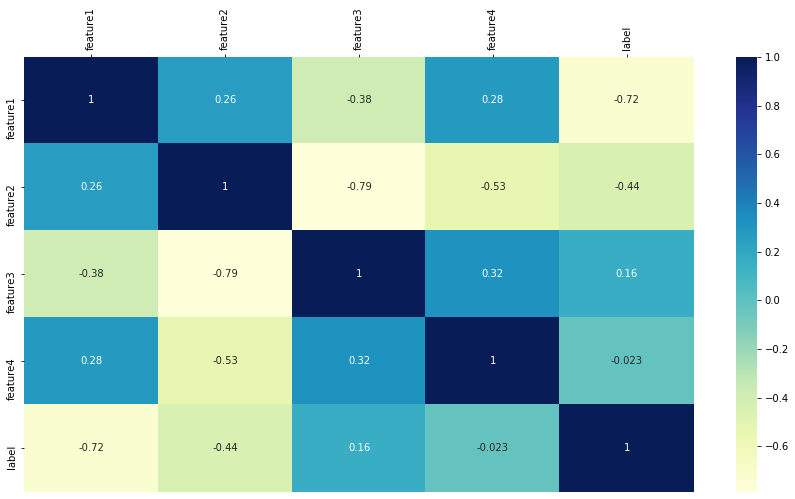

In [45]:
df_pd=data.toPandas()
plt.subplots(figsize=(15,8))
hm1=sns.heatmap(df_pd.corr(),annot=True,cmap='YlGnBu')
hm1.set_xticklabels(hm1.get_xticklabels(), rotation=90)
hm1.xaxis.set_ticks_position('top')

In [78]:
splits=data.randomSplit([0.8,0.2])
df_train=splits[0]
df_test=splits[1]

In [79]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler,Normalizer
vectorizer=VectorAssembler(inputCols=["feature1","feature2","feature3","feature4"],outputCol="vecfeatures")
normalizer=Normalizer(inputCol="vecfeatures",outputCol="features",p=1.0)

In [80]:
from pyspark.ml.classification import GBTClassifier
gbt=GBTClassifier()

In [81]:
from pyspark.ml import Pipeline
pipeline=Pipeline(stages=[vectorizer,normalizer,gbt])

In [82]:
model=pipeline.fit(df_train)
pred_train=model.transform(df_train)
pred_test=model.transform(df_test)

In [83]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
binEval=MulticlassClassificationEvaluator().setMetricName("accuracy").setPredictionCol("prediction").setLabelCol("label")

In [84]:
binEval.evaluate(pred_train)

0.998193315266486

In [85]:
binEval.evaluate(pred_test)

0.9962264150943396

In [69]:
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder


In [70]:
paramGrid=ParamGridBuilder()\
    .addGrid(normalizer.p,[1.0,2.0,10.0])\
    .addGrid(gbt.maxBins,[2,4,8,16])\
    .addGrid(gbt.maxDepth,[2,4,8,16])\
    .build()

In [72]:
crossVal=CrossValidator(estimator=pipeline,estimatorParamMaps=paramGrid,evaluator=MulticlassClassificationEvaluator(),numFolds=4)

In [73]:
cvModel=crossVal.fit(df_train)

Exception ignored in: <function JavaWrapper.__del__ at 0x7f648ecd18c0>
Traceback (most recent call last):
  File "/home/altaf/anaconda3/lib/python3.7/site-packages/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'VectorAssembler' object has no attribute '_java_obj'


In [74]:
pred_train=cvModel.transform(df_train)
pred_test=cvModel.transform(df_test)

In [75]:
binEval.evaluate(pred_train)

1.0

In [76]:
binEval.evaluate(pred_test)

0.9961240310077519

In [77]:
pred_train.head()

Row(feature1=-7.0421, feature2=9.2, feature3=0.25933, feature4=-4.6832, label=1, vecfeatures=DenseVector([-7.0421, 9.2, 0.2593, -4.6832]), features=DenseVector([-0.3324, 0.4343, 0.0122, -0.2211]), rawPrediction=DenseVector([-1.5435, 1.5435]), probability=DenseVector([0.0436, 0.9564]), prediction=1.0)